In [104]:
from data_generation import generate_data
import os
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mlflow 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
from optbinning import OptimalBinning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import f_oneway
import sweetviz as sv
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [16]:
generate_data(10)

,party_id,risk_probability,high_risk_flag,AVG BILL L1M,AVG BILL RENTAL L1M,AVG BILL RENTAL L2M,AVG BILL RENTAL L3M,AVG BILL RENTAL L4M,AVG BILL RENTAL L5M,AVG BILL RENTAL L6M,...,PERCENT DEBT-FREE ACCOUNTS,AVG DEBT-FREE ACCOUNTS L1M,PERCENT DEBT-FREE ACCOUNTS L1M,PRIMARY-CHANNEL PAYMENT SHARE L1M,CORPORATION SEGMENT,CUSTOMER REVENUE BAND SEGMENT,CUSTOMER PROFIT SEGMENT,CUSTOMER TYPE,CUSTOMER VALUE SEGMENT,PRIMARY-CHANNEL FOR PAYMENT
0,0,0.571403,0,2196.441985,1209.238168,-939.398897,393.123828,218.192610,281.740945,-179.220801,...,3.686916,-0.560704,1.512639,1.635012,Unknown,Unknown,WELCOME,CONSUMER,Unknown,Unknown
1,1,0.428889,0,4239.366207,-377.899300,1184.986572,1429.862515,191.921836,-84.500929,226.160278,...,-0.426024,-0.253372,1.549014,0.020382,Unknown,PRESTIGE,SILVER,CONSUMER,Unknown,Unknown
2,2,0.578091,0,3637.339769,174.566882,742.655734,2403.251357,767.806576,318.755056,-177.893534,...,-0.297984,0.231769,2.278342,1.636763,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Unknown
3,3,0.206098,0,2043.434692,256.637478,1459.135417,-807.322753,-313.779727,111.087357,333.488024,...,0.448937,0.870034,1.170390,0.381200,Missing,NEW CUST,PRESTIGE BY MGMT,CONSUMER,Platinum,Loyalty
4,4,0.813321,0,1991.886347,625.391245,-34.290689,161.543642,767.201722,623.862901,-0.305920,...,1.316193,0.882452,0.933656,-1.325184,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet
5,5,0.823589,0,6140.618365,-782.393947,6581.499690,728.646715,552.416536,257.291294,-149.365007,...,-0.436448,1.080909,-0.447611,2.599109,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet
6,6,0.653473,0,525.199651,1441.017073,1847.815829,-1238.256244,-64.186216,402.794964,-63.397444,...,0.347543,-0.641084,-0.812816,-1.511124,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet
7,7,0.160230,0,3478.346738,-245.656346,-1240.949496,1000.406369,29.023322,-111.390774,-181.102101,...,1.884685,0.510296,2.112856,-0.618168,Missing,Missing,None,CONSUMER,Platinum,None
8,8,0.520669,0,4896.174103,438.558535,1191.160162,202.027891,154.447943,304.647984,271.832434,...,0.032398,0.186923,1.391038,2.357667,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet
9,9,0.327773,0,2443.089409,725.884095,372.784442,850.141610,535.540517,425.972831,-248.536205,...,0.102992,-0.832317,1.607057,0.396679,Missing,NEW CUST,SILVER,CONSUMER,Unknown,Loyalty


## Data preprocessing

In [17]:
def SeperateDataTypes(df):
    numeric_cols = df.drop(columns = ['party_id','risk_probability','high_risk_flag']).select_dtypes(include = ['number']).columns.tolist()
    obj_cols = df.drop(columns = ['party_id','risk_probability','high_risk_flag']).select_dtypes(exclude = ['number']).columns.tolist()
    cols = {'numeric':numeric_cols, 'obj':obj_cols}
    return cols

def WeightOfEvidence(df, target):
    seperated_cols = SeperateDataTypes(df)
    temp_df = df.copy()
    numeric = pd.DataFrame()
    for variable in seperated_cols['numeric']:
        numeric[variable] = CreateWoEColumn(temp_df, variable, target)
    for variable in seperated_cols['obj']:
        temp_df[variable] = CreateBins(temp_df, variable, target)
        numeric[variable] = CreateWoEColumn(temp_df, variable, target)
    numeric[target] = df[target]
    return numeric

def CreateWoEColumn(df, variable, target):
    x = df[variable].values
    y = df[target].values
    optb = OptimalBinning(name=variable, dtype='numerical', solver="cp")
    optb.fit(x, y)
    return optb.transform(x, metric = 'woe')

def CreateBins(df, variable, target):
    grouped_df = df.groupby(variable).agg({target : ['mean','std']}).round(2).reset_index()
    cols = [variable,'mean', 'std']
    grouped_df.columns = cols
    grouped_df.fillna(0, inplace = True)
    grouped_df['map'] = (grouped_df['mean'].astype(str) + '_' + grouped_df['std'].astype(str)).rank(method='dense')
    grouped_df[[variable,'map']]
    return df[variable].map(grouped_df.set_index(variable)['map'])
    
def CreateFeatureDF(df, target):
    from sklearn.preprocessing import MinMaxScaler
    col_types = SeperateDataTypes(df)
    numeric = df[col_types['numeric']]
    obj = df[col_types['obj']]
    for col in numeric.columns:
        scaler = MinMaxScaler()
        numeric[col] = scaler.fit_transform(numeric[[col]])
    for col in obj.columns:
        le = LabelEncoder()
        le.fit(obj[col])
        obj[col] = le.transform(obj[col])
    return pd.concat([df[[target]],numeric, obj], axis = 1)


## Feature Selection

In [18]:
def RunFeatureSelection(X_train, y_train, top_n=False):
    important_feature_list = []
    feature_importance_df = pd.DataFrame()
    grid = {
        'RandomForest':RandomForestClassifier(),
        'DecisionTree':DecisionTreeClassifier(),
        'XGBoost':XGBClassifier()
    }
    if top_n:
        for model_name in grid.keys():
            model = grid[model_name]
            model.fit(X_train, y_train)
            feature_imp = pd.DataFrame({'var':model.feature_names_in_, 'imp':model.feature_importances_})
            feature_imp.sort_values('imp', ascending = False, inplace = True)
            important_feature_list.extend(feature_imp.head(top_n)['var'].values)
        important_feature_list = np.unique(important_feature_list)
        return important_feature_list
    else:
        for model_name in grid.keys():
            model = grid[model_name]
            model.fit(X_train, y_train)
            feature_imp = pd.DataFrame({'var':model.feature_names_in_, 'imp':model.feature_importances_})
            feature_imp.sort_values('imp', ascending = False, inplace = True)
            feature_imp['ModelName'] = model_name
            feature_imp = feature_imp[feature_imp.imp>0]
            feature_importance_df = pd.concat([feature_importance_df, feature_imp])            
        return feature_importance_df


## Grid Search

In [202]:
def RunModelSearch(X_train,y_train,X_test, y_test, experiment_name, run_prefix):
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    mlflow.sklearn.autolog(disable=True)
    mlflow.set_experiment(experiment_name = experiment_name)
    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'XGBoost': XGBClassifier(objective='binary:logistic', random_state=42),
        'LGBM': LGBMClassifier()
    }
    
    # Define parameter grids for each classifier
    param_grids = {
        'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
        'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
        'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
        'XGBoost': {'max_depth': [3, 6, 9], 'learning_rate': [0.1, 0.01, 0.001]},
        'LGBM': {'max_depth': [3, 6, 9], 'learning_rate': [0.1, 0.01, 0.001]}
    }
    best_model_name_ = ''
    best_model_params_ = ''
    best_model_recall = -np.inf
    # Perform grid search and evaluate each classifier
    for classifier_name, classifier in classifiers.items():
        print(f"Running GridSearchCV for {classifier_name}...")
        
        # Perform grid search
        with mlflow.start_run(run_name=run_prefix+'_'+classifier_name) as run:
            grid_search = GridSearchCV(classifier, param_grid=param_grids[classifier_name], cv=3, scoring='accuracy')
            grid_search.fit(X_train, y_train)
        
            # Get best parameters and best estimator
            best_params = grid_search.best_params_
            best_estimator = grid_search.best_estimator_
            
            # Make predictions
            y_pred = best_estimator.predict(X_test)
            recall_metric = recall_score(y_test, y_pred)
            if recall_metric > best_model_recall:
                best_model_name = classifier_name
                best_model_params_ = best_params
                best_model_recall = recall_metric
                best_model_estimator = best_estimator
            
            # Evaluate model performance
            metrics = {
                'accuracy':round(accuracy_score(y_test, y_pred)*100,2),
                'recall':round(recall_score(y_test, y_pred)*100,2),
                'precision':round(precision_score(y_test, y_pred)*100,2),
                'f1_score':round(f1_score(y_test, y_pred)*100,2),
                'Final_Model':0
            }                        
            mlflow.sklearn.log_model(best_estimator, "finalized_model")
            mlflow.log_param('best_params',best_params)
            mlflow.log_metrics(metrics)
            LogConfusionMatrix(run, y_test, y_pred)

            

def LogConfusionMatrix(run, y_test, y_pred): 
    cm = confusion_matrix(y_test, y_pred)
    labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cm = cm.reshape((2, 2))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    confusion_matrix_file = "confusion_matrix.png"
    plt.savefig(confusion_matrix_file)
    with run:
        mlflow.log_artifact(confusion_matrix_file, artifact_path="confusion_matrix")

import mlflow.sklearn
def FinalizeModel(experiment_name, metric):
    print("Finalizing Model")
    runs_df = mlflow.search_runs(experiment_names=[experiment_name])
    best_run_id = runs_df[runs_df['metrics.'+metric] == runs_df['metrics.'+metric].max()]['run_id'].tolist()[0]
    run_ids = runs_df['run_id'].to_list()

    # Set the FINAL_MODEL metric for each run
    for r in run_ids:
        with mlflow.start_run(run_id=r) as run:
            if r == best_run_id:
                mlflow.log_metric('FINAL_MODEL', 1)
            else:
                mlflow.log_metric('FINAL_MODEL', 0)
    loaded_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/finalized_model")
    mlflow.register_model(
        model_uri = f"runs:/{best_run_id}/finalized_model",
        name = 'ProductionModels',
        tags = None
    )
    return loaded_model

#### Noise Control for Data Generation

In [203]:
def prob_return(num):
    mu = 0
    sigma = 0.8
    return np.random.normal(mu, sigma, num)
def create_categorical(df, pop_vals, col_name):
    le = LabelEncoder()
    le.fit(pop_vals)
    le.transform(pop_vals)
    noisy_probs = (df['risk_probability'] + np.random.beta(10,15,size = len(df)) )
    noisy_probs = [0.99 if i>1 else i for i in noisy_probs]
    values = [int(i*len(pop_vals)) for i in noisy_probs]
    transformed = le.inverse_transform(values)
    df[col_name]  = transformed
    return df

## Data Visualization

In [204]:
df = generate_data(1000)
# my_report = sv.analyze(df, target_feat='high_risk_flag')
# my_report.show_html()

## Main Script

2024/04/29 15:16:36 INFO mlflow.tracking.fluent: Experiment with name 'ModelGridSearch_2024_04_29_15_16_35' does not exist. Creating a new experiment.


Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Random Forest...
Running GridSearchCV for Decision Tree...
Running GridSearchCV for XGBoost...
Running GridSearchCV for LGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 42, number of negative: 491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3939
[LightGBM] [Info] Number of data points in the train set: 533, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078799 -> initscore=-2.458775
[LightGBM] [Info] Start training from score -2.458775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

Registered model 'ProductionModels' already exists. Creating a new version of this model...
2024/04/29 15:17:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ProductionModels, version 3
Created version '3' of model 'ProductionModels'.


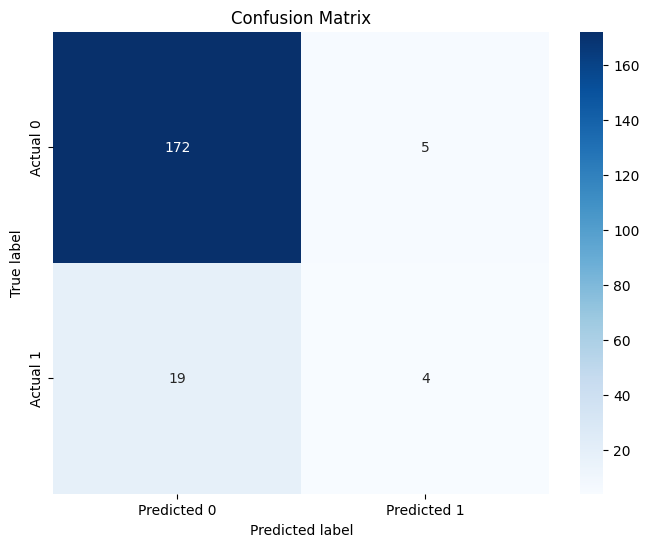

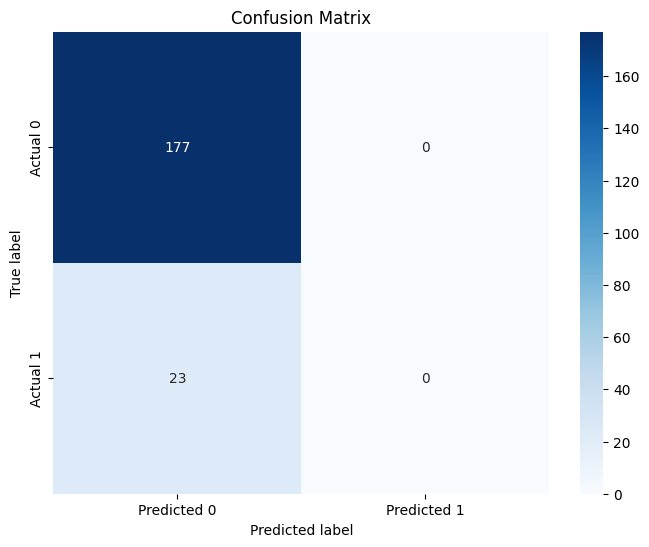

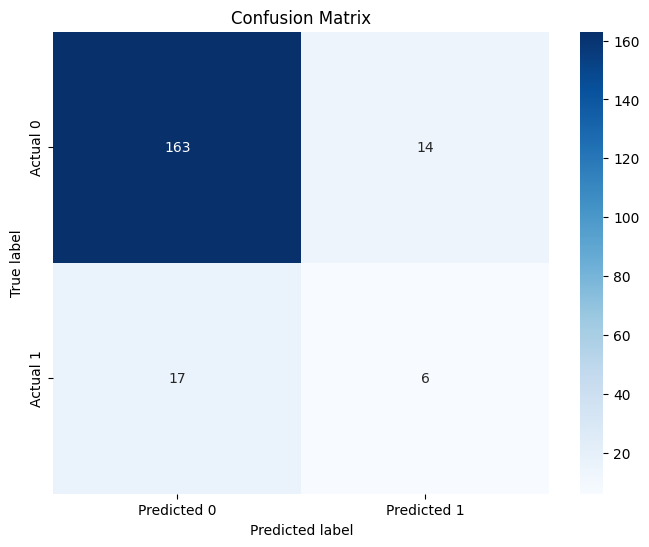

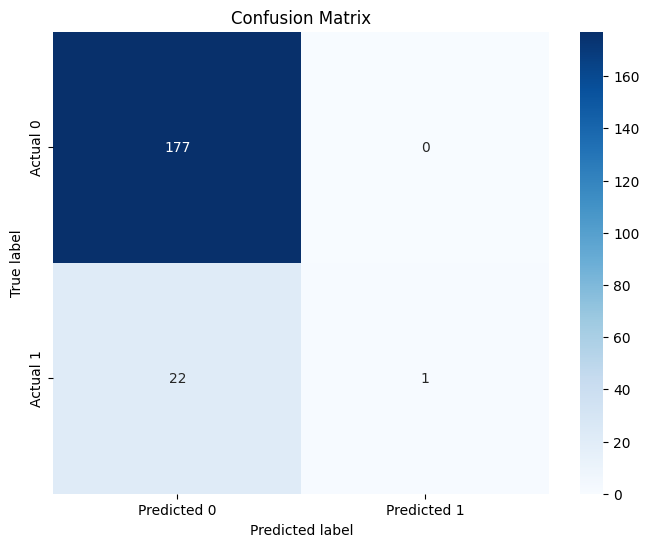

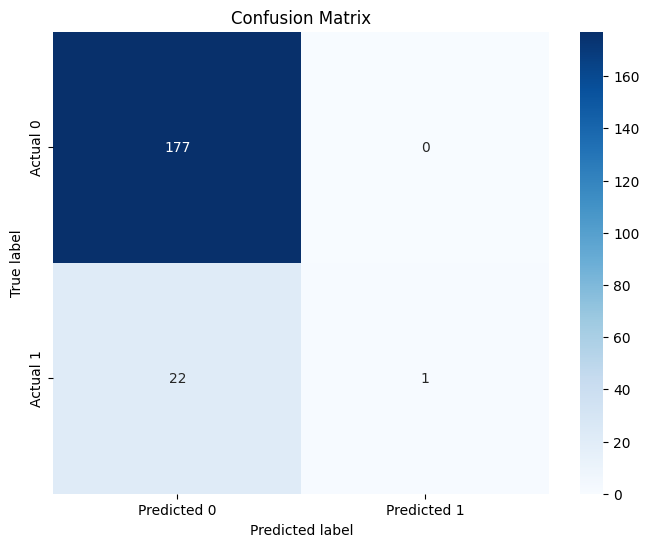

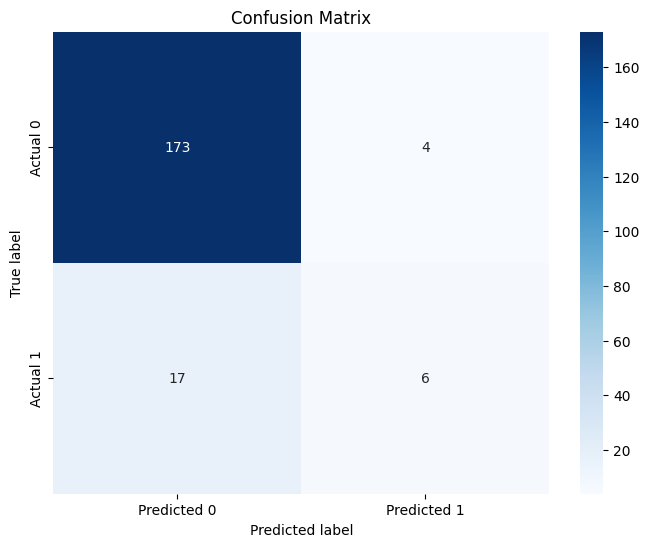

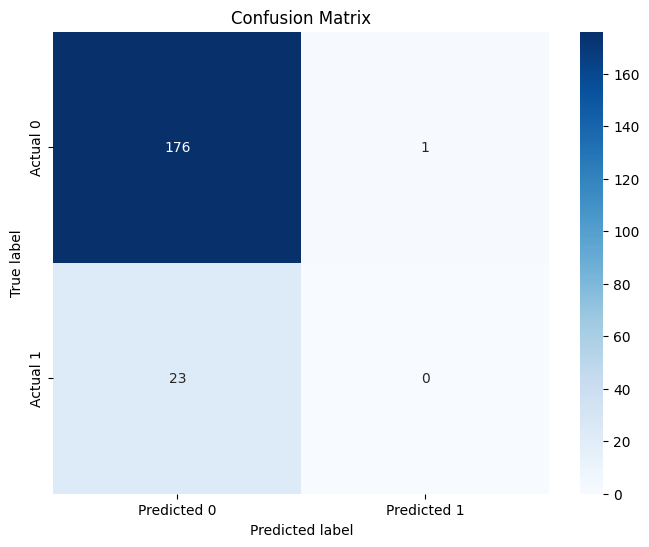

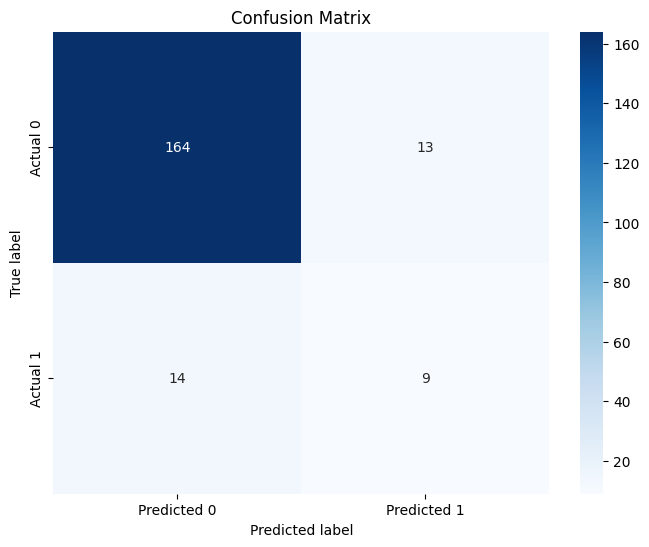

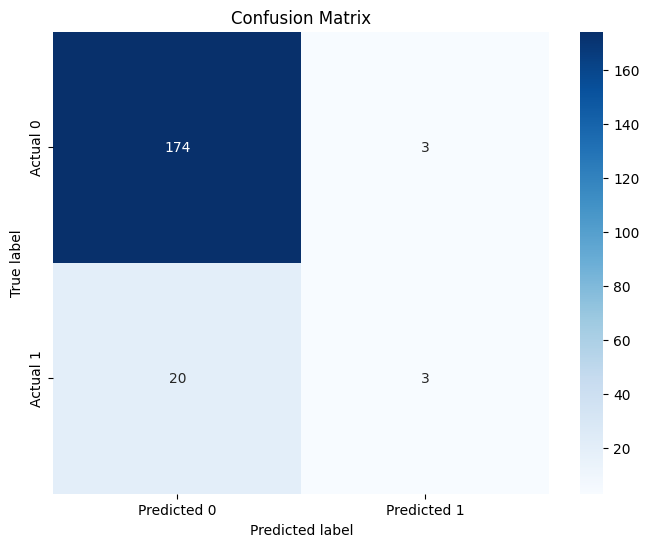

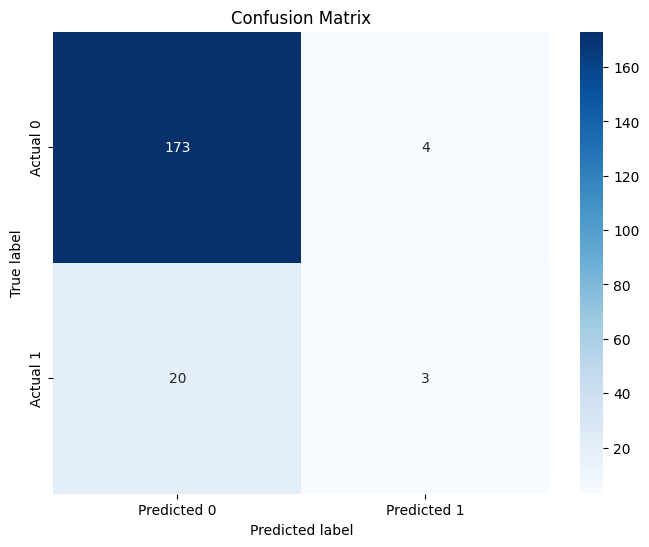

In [205]:
woe_df = WeightOfEvidence(df,'high_risk_flag')
feature_df = CreateFeatureDF(df,'high_risk_flag')
experiment_name=f'ModelGridSearch_'+datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns = ['high_risk_flag']), 
                                                    feature_df.high_risk_flag, 
                                                    test_size=0.2, 
                                                    random_state=42)
selected_features = RunFeatureSelection(X_train, y_train, top_n=10)
RunModelSearch(X_train[selected_features], y_train, X_test[selected_features], y_test, experiment_name=experiment_name, run_prefix='Scaled')

X_train, X_test, y_train, y_test = train_test_split(woe_df.drop(columns = ['high_risk_flag']), 
                                                    woe_df.high_risk_flag, 
                                                    test_size=0.2, 
                                                    random_state=42)
selected_features = RunFeatureSelection(X_train, y_train, top_n=10)
RunModelSearch(X_train[selected_features], y_train, X_test[selected_features], y_test, experiment_name=experiment_name, run_prefix='WoE')
model = FinalizeModel(experiment_name, metric='accuracy')


## Rough work

In [201]:
import shap as sp

In [239]:
# experiment_names = [exp.name for exp in mlflow.tracking.MlflowClient().list_experiments()]
# experiment_names
client = mlflow.tracking.MlflowClient()
experiements = client.search_experiments()
ids = []
names = []
for i in range(len(experiements)):
    experimentID = str(experiements[i]).split("experiment_id='")[1].split("'")[0]
    experimentName = str(experiements[i]).split("name='")[1].split("'")[0]
    ids.append(experimentID)
    names.append(experimentName)
df = pd.DataFrame({'id':ids,'name':names})
ids_to_delete = df[df.name.str.contains('2024_04_29_14')==False]['id'].tolist()
for ids in ids_to_delete:
    mlflow.delete_experiment(experiment_id=ids)

MlflowException: API request to http://127.0.0.1:5000/api/2.0/mlflow/experiments/delete failed with exception HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/delete (Caused by ResponseError('too many 500 error responses'))

In [175]:
mlflow.set_experiment(experiment_name='Testing2')

classifiers = {
    'XGBoost': XGBClassifier(objective='binary:logistic', random_state=42)
}

# Define parameter grids for each classifier
param_grids = {
    'XGBoost': {'max_depth': [3, 6, 9], 'learning_rate': [0.1, 0.01, 0.001]}
}
for classifier_name, classifier in classifiers.items():
    with mlflow.start_run(run_name=classifier_name) as run:
            grid_search = GridSearchCV(classifier, param_grid=param_grids[classifier_name], cv=3, scoring='accuracy')
            grid_search.fit(X_train, y_train)
            best_params = grid_search.best_params_
            best_estimator = grid_search.best_estimator_
            y_pred = best_estimator.predict(X_test)
            mlflow.sklearn.log_model(best_estimator, "finalized_model")


In [51]:
recall_temp = -np.inf

for mlflow.search_runs(experiment_names=[experiment_name]).iterrows():
    run_name = run[1]['tags.mlflow.runName']
    recall = run[1]['metrics.recall']
    if recall > recall_temp:
        recall_temp = recall
        best_model = run_name


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.recall,metrics.f1_score,metrics.accuracy,metrics.precision,params.best_params,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.runName
0,7e261d68ea514364b15fde83387f77f0,647061717278565364,FINISHED,mlflow-artifacts:/647061717278565364/7e261d68e...,2024-04-29 08:27:47.123000+00:00,2024-04-29 08:27:48.139000+00:00,0.0,0.0,90.0,0.0,"{'learning_rate': 0.1, 'max_depth': 3}",D:\anaconda3\envs\assetdev\lib\site-packages\i...,LOCAL,shahryar.akhtar,Scaled_LGBM
1,0c07cd5b8bff4fd39f7a7ea4b3f59bc6,647061717278565364,FINISHED,mlflow-artifacts:/647061717278565364/0c07cd5b8...,2024-04-29 08:27:45.319000+00:00,2024-04-29 08:27:47.100000+00:00,0.0,0.0,90.0,0.0,"{'learning_rate': 0.1, 'max_depth': 3}",D:\anaconda3\envs\assetdev\lib\site-packages\i...,LOCAL,shahryar.akhtar,Scaled_XGBoost
2,ca8beac36bd04c98963a40611d8e17eb,647061717278565364,FINISHED,mlflow-artifacts:/647061717278565364/ca8beac36...,2024-04-29 08:27:44.985000+00:00,2024-04-29 08:27:45.290000+00:00,0.0,0.0,90.0,0.0,"{'max_depth': None, 'min_samples_split': 2}",D:\anaconda3\envs\assetdev\lib\site-packages\i...,LOCAL,shahryar.akhtar,Scaled_Decision Tree
3,03b8360c321d44199de77e4da25d37c7,647061717278565364,FINISHED,mlflow-artifacts:/647061717278565364/03b8360c3...,2024-04-29 08:27:40.808000+00:00,2024-04-29 08:27:44.968000+00:00,0.0,0.0,90.0,0.0,"{'max_depth': None, 'n_estimators': 50}",D:\anaconda3\envs\assetdev\lib\site-packages\i...,LOCAL,shahryar.akhtar,Scaled_Random Forest
4,07083d040e064639a41c234fdcbdad23,647061717278565364,FINISHED,mlflow-artifacts:/647061717278565364/07083d040...,2024-04-29 08:27:40.547000+00:00,2024-04-29 08:27:40.792000+00:00,0.0,0.0,85.0,0.0,{'C': 10},D:\anaconda3\envs\assetdev\lib\site-packages\i...,LOCAL,shahryar.akhtar,Scaled_Logistic Regression


In [77]:
runs_df = mlflow.search_runs(experiment_names=[experiment_name])
# runs_df
best_run_id = runs_df[runs_df['metrics.recall'] == runs_df['metrics.recall'].min()]['run_id']
# run_ids = runs_df['run_id'].to_list()
# for r in run_ids:
#         with mlflow.start_run(run_id=r) as run:
#             if r == best_run_id:
#                 mlflow.log_metric('FINAL_MODEL', 1)
#             else:
#                 mlflow.log_metric('FINAL_MODEL', 0)

KeyError: 0

'1f164e8d209a4b5ea881a8cf4b157f7f'